In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
diabetes_data = pd.read_csv("/Users/nithinshankar/Documents/DiabetesPrediction/diabetes.csv")
diabetes_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


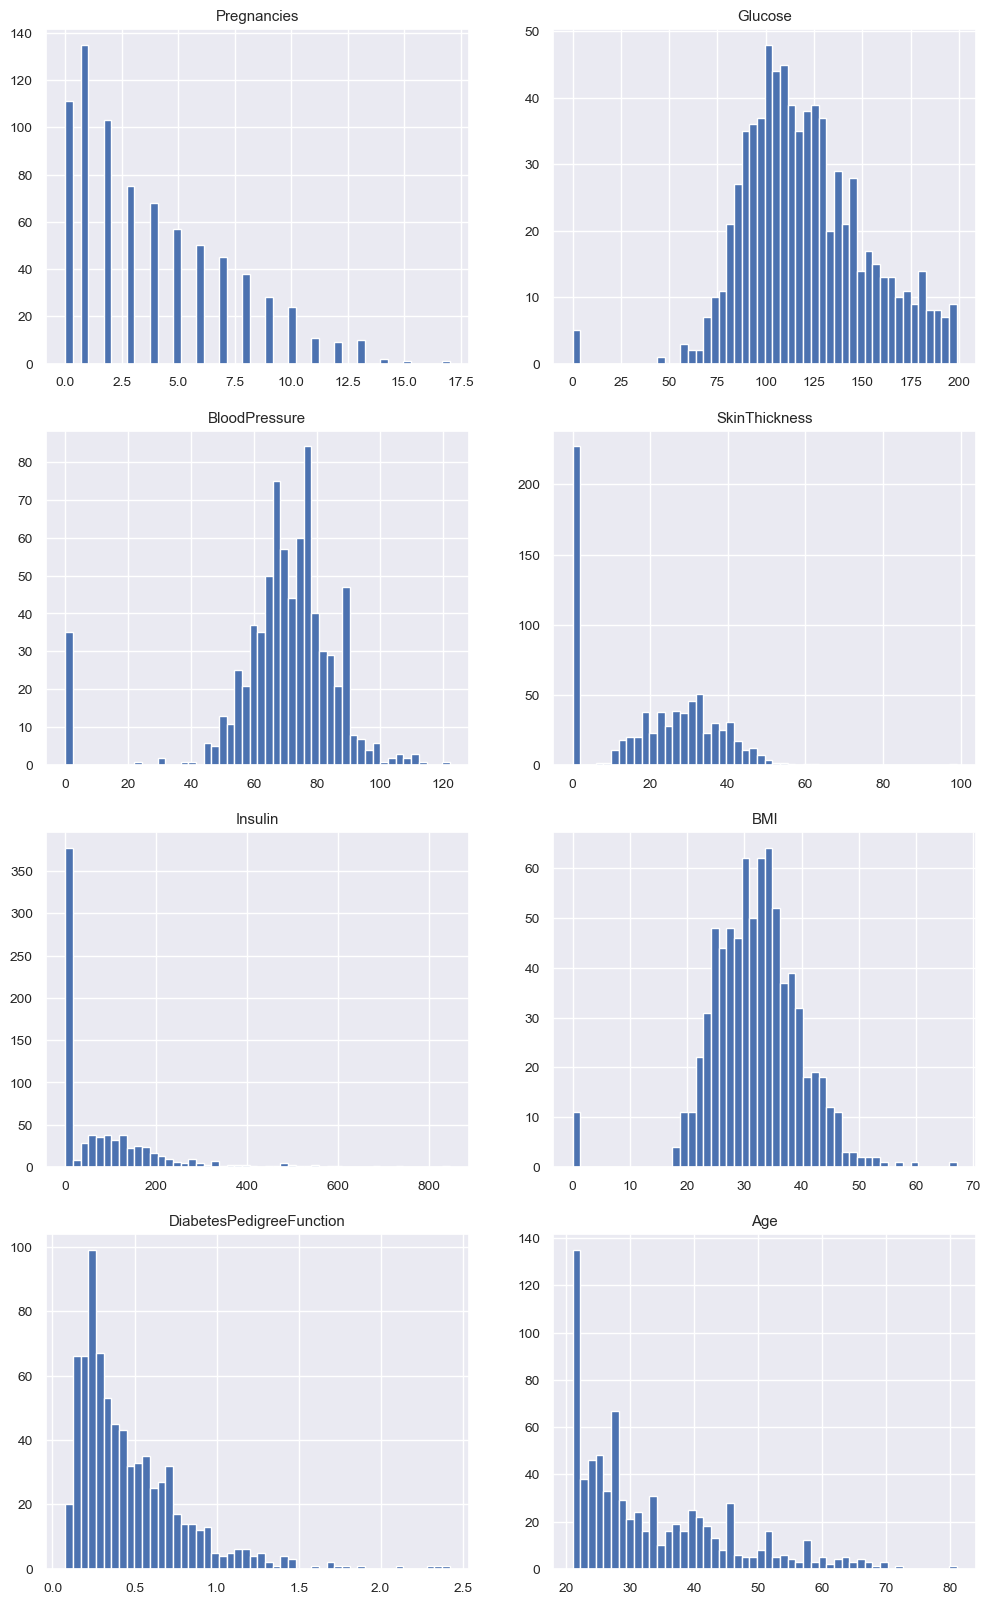

In [43]:
# Plot histograms for the features
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for row in range(4):
    for col in range(2):
        feature_idx = row * 2 + col
        axes[row, col].hist(diabetes_data.iloc[:, feature_idx], bins=50)
        axes[row, col].set_title(diabetes_data.columns[feature_idx])
        axes[row, col].grid(True)

plt.show()


In [45]:
# Check for missing values
print(np.sum(diabetes_data.isna(), axis=0))


# Separate features and target
features = diabetes_data.drop('Outcome', axis=1)
target = diabetes_data['Outcome']

# Check distribution of target labels
target_distribution = target.value_counts()
print(target_distribution)



Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Outcome
0    500
1    268
Name: count, dtype: int64


In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import time
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D  
import numpy as np

def model_train_eval(features, target, learning_rate_value):
    """
    Trains and evaluates a model using 5-fold cross-validation.
    Plots the loss and accuracy curves and the ROC curves for all folds.

    Parameters:
    features (array-like): 2D-array of input features.
    target (array-like): list of target labels.
    learning_rate_value (float): learning rate for SGD optimizer.
    
    Returns:
    avg_accuracy (float): mean accuracy across all folds.
    avg_auc (float): mean AUC across all folds.
    avg_time (float): mean execution time across all folds.
    """
    
    n_folds = 5  
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracy_scores = []
    auc_scores = []
    execution_times = []
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['r', 'g', 'b', 'c', 'm'] 
    line_styles = ['-', '--', '-.', ':']

    # Define the model once outside the loop to avoid retracing issues
    def build_model(input_shape):
        model = Sequential()
        model.add(Input(shape=input_shape))  # Use Input layer here
        model.add(Dense(1, activation='sigmoid'))
        optimizer = SGD(learning_rate=learning_rate_value)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    for i, (train_index, test_index) in enumerate(skf.split(features, target)): 
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Build and compile the model
        model = build_model(X_train.shape[1:])

        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5)
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=1000, batch_size=32, 
                            validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
        end_time = time.time()

        # Model validation
        y_pred_prob = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc_value = roc_auc_score(y_test, y_pred_prob)
        _, acc_value = model.evaluate(X_test, y_test, verbose=0)

        # Store results
        accuracy_scores.append(acc_value)
        auc_scores.append(auc_value)
        execution_times.append(end_time - start_time)

        # Plot loss, accuracy, and ROC curve
        ax1.plot(history.history['loss'], linestyle=line_styles[0], color=colors[i])
        ax1.plot(history.history['val_loss'], linestyle=line_styles[1], color=colors[i])
        ax1.plot(history.history['accuracy'], linestyle=line_styles[2], color=colors[i])
        ax1.plot(history.history['val_accuracy'], linestyle=line_styles[3], color=colors[i])
        ax2.plot(fpr, tpr, linestyle='-', color=colors[i])

    # Plot titles and labels
    ax1.set_title('Loss and Accuracy Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss / Accuracy')

    ax2.set_title('ROC Curves')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')

    avg_accuracy = np.mean(accuracy_scores)
    avg_auc = np.mean(auc_scores)
    avg_time = np.mean(execution_times)

    print(f"Mean Accuracy: {avg_accuracy:.3f}")
    print(f"Mean AUC: {avg_auc:.3f}")
    print(f"Mean Execution Time: {avg_time:.3f} seconds")

    return avg_accuracy, avg_auc, avg_time


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Accuracy: 0.758
Mean AUC: 0.812
Mean Execution Time: 13.945 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Accuracy: 0.768
Mean AUC: 0.834
Mean Execution Time: 10.178 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Accuracy: 0.763
Mean AUC: 0.829
Mean Execution Time: 2.851 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Accuracy: 0.766
Mea

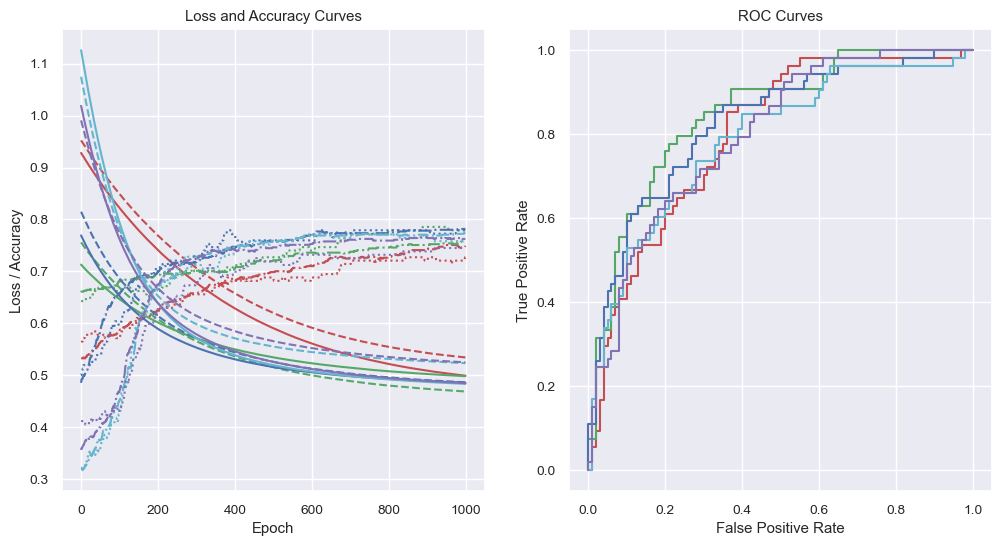

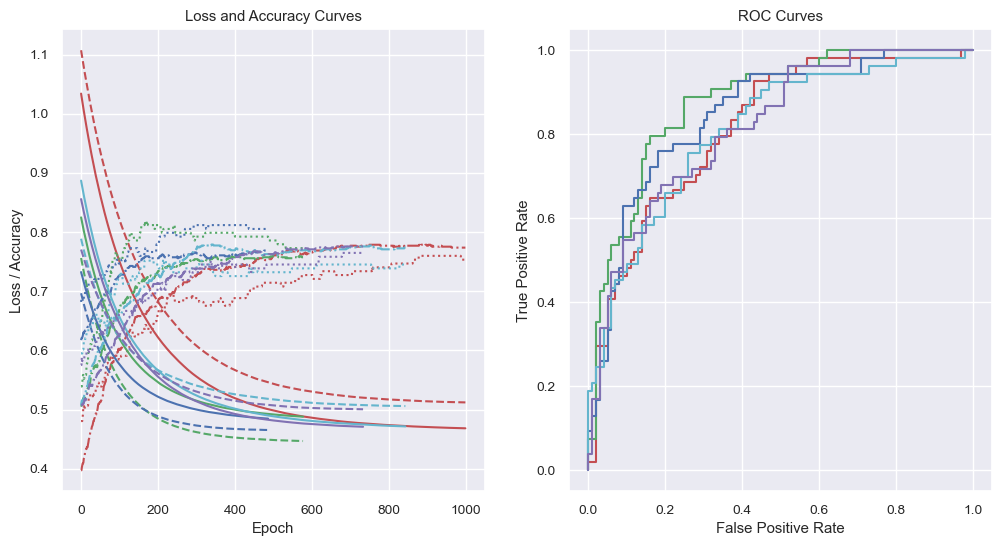

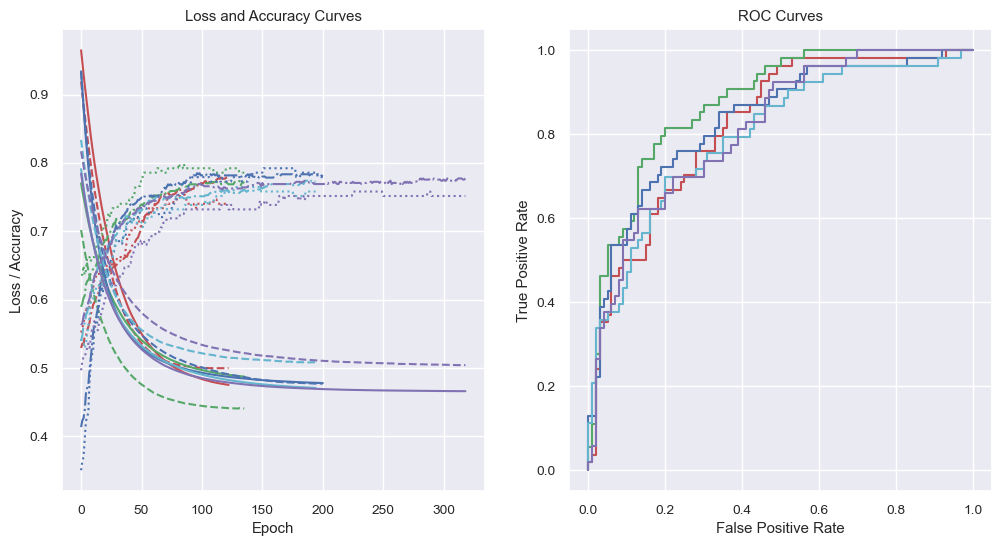

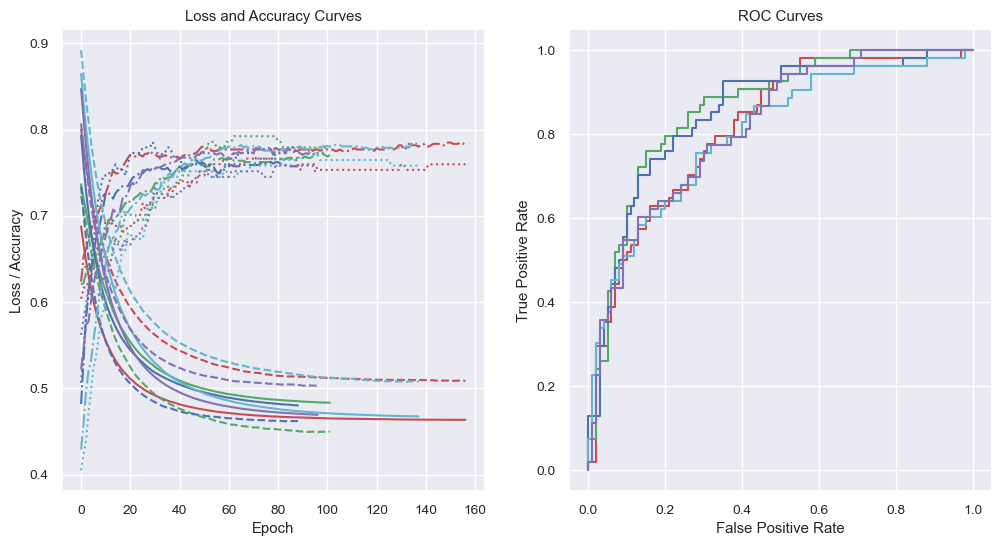

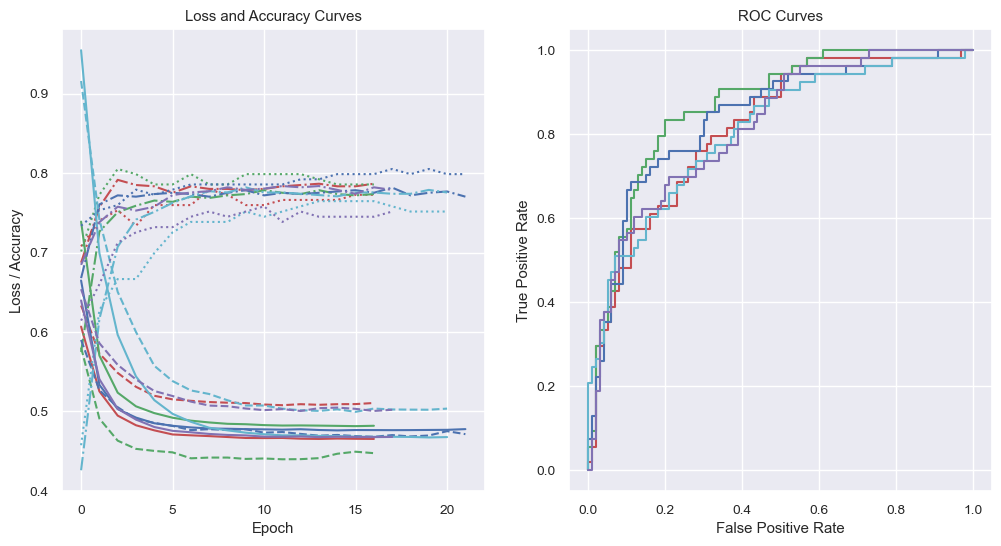

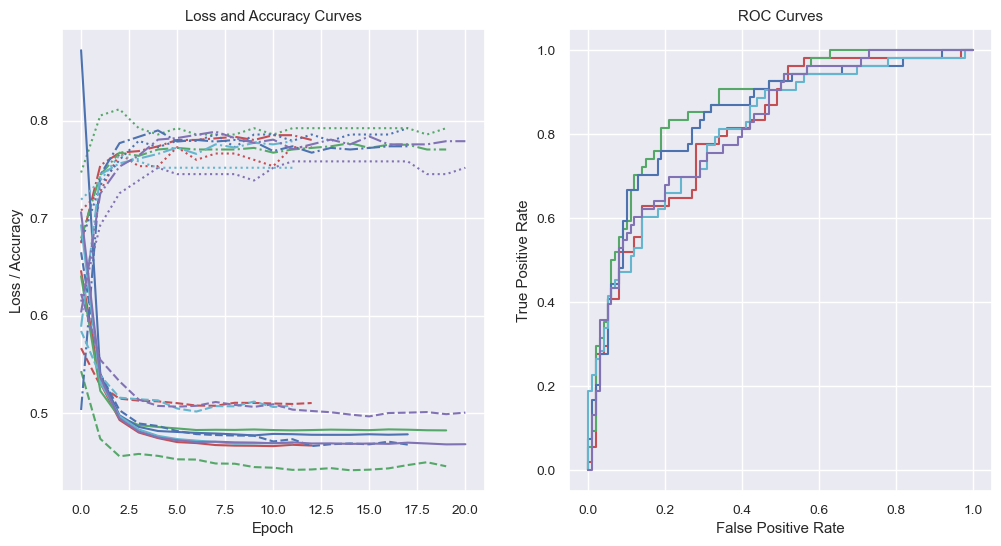

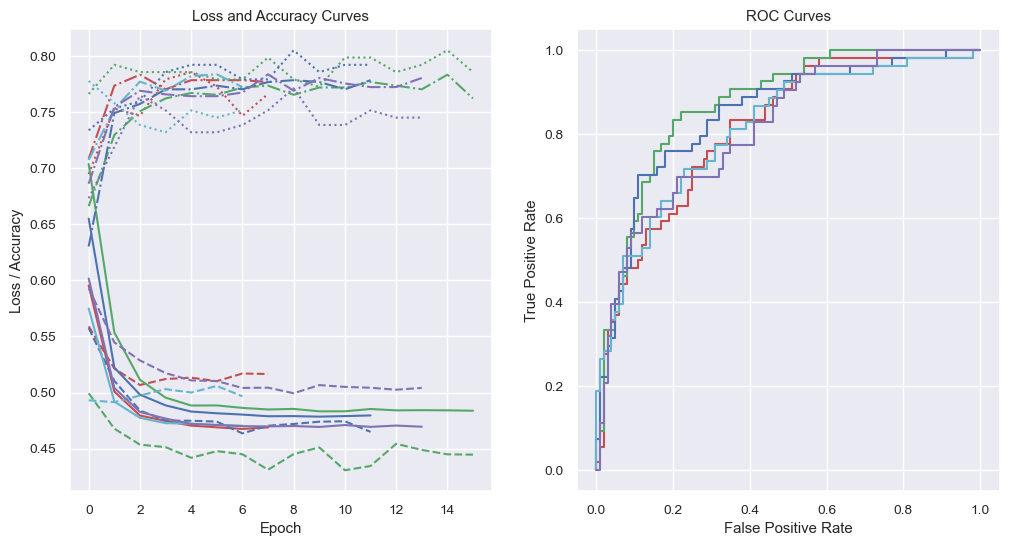

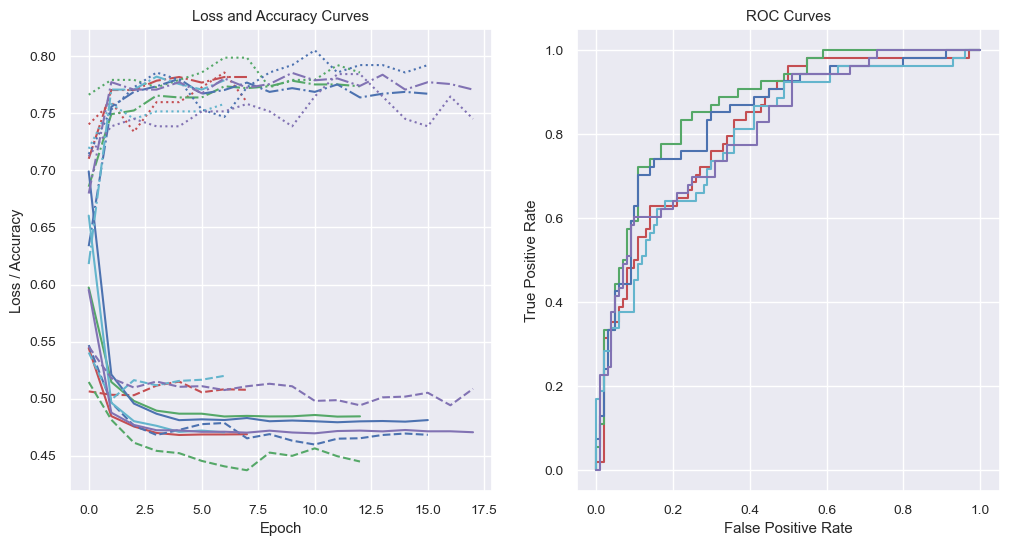

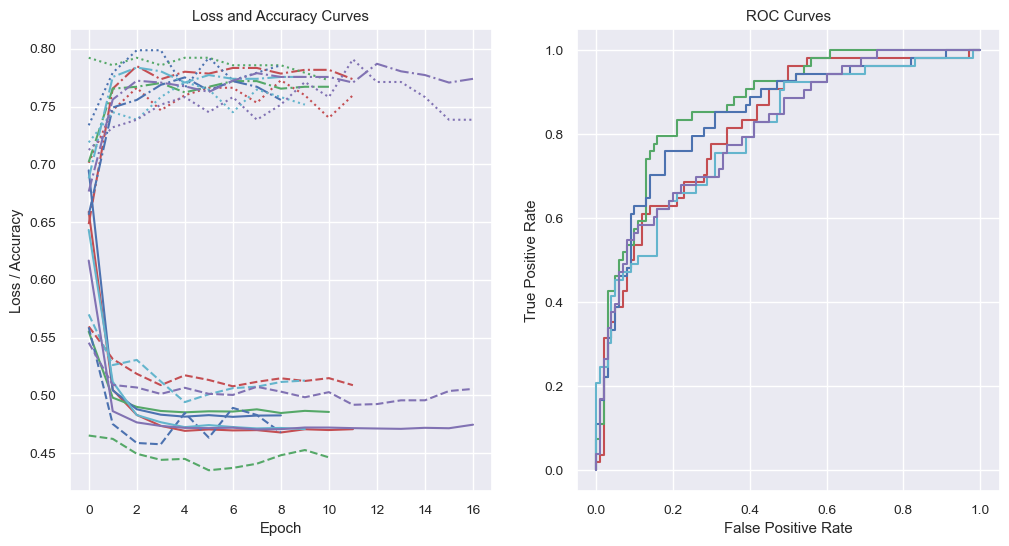

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=0.9)

learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3] 

# Dictionary to store the results
results = {'learning_rate': [], 'avg_accuracy': [], 'avg_auc': [], 'avg_time': []}

# Train and evaluate for each learning rate
for rate in learning_rates:
    avg_acc, avg_auc, avg_time = model_train_eval(features, target, rate)
    results['learning_rate'].append(str(rate))
    results['avg_accuracy'].append(avg_acc * 100)
    results['avg_auc'].append(avg_auc)
    results['avg_time'].append(avg_time)


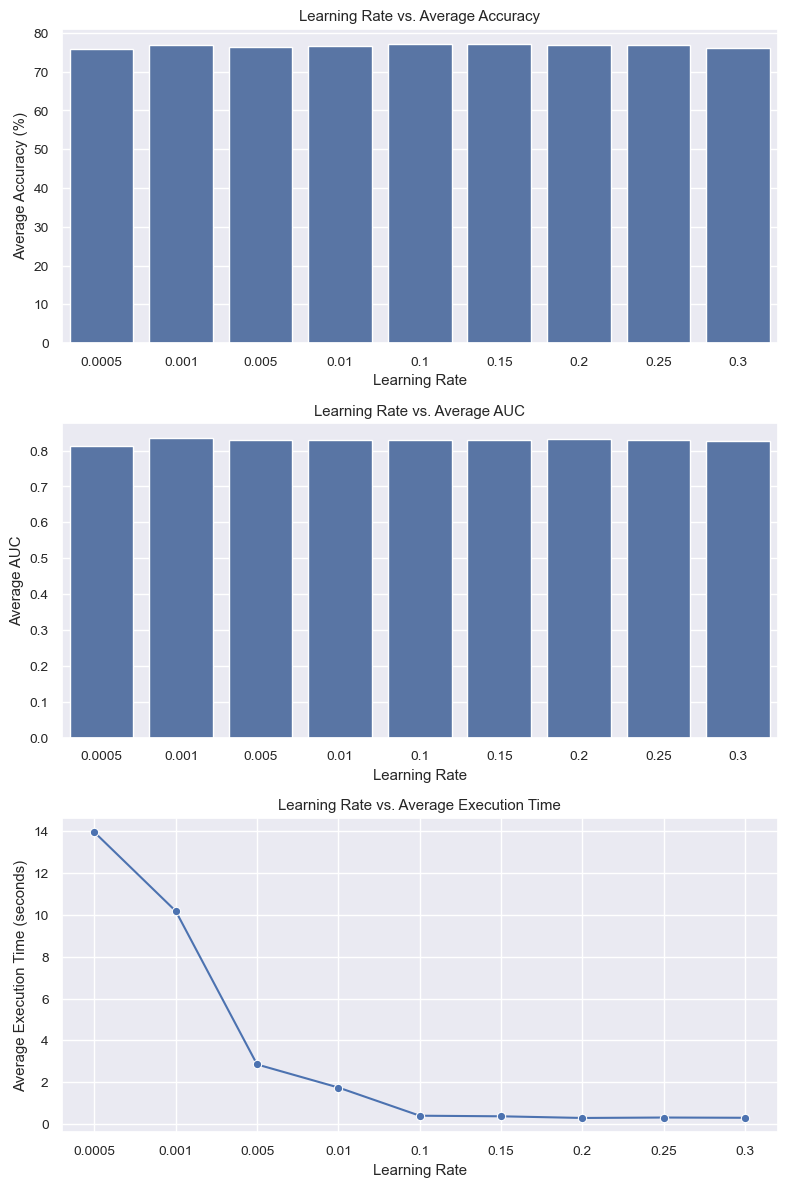

In [37]:
# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot accuracy
sns.barplot(x='learning_rate', y='avg_accuracy', data=results, ax=axs[0])
axs[0].set_title('Learning Rate vs. Average Accuracy')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Average Accuracy (%)')

# Plot AUC
sns.barplot(x='learning_rate', y='avg_auc', data=results, ax=axs[1])
axs[1].set_title('Learning Rate vs. Average AUC')
axs[1].set_xlabel('Learning Rate')
axs[1].set_ylabel('Average AUC')

# Plot execution time
sns.lineplot(x='learning_rate', y='avg_time', data=results, marker='o', ax=axs[2])
axs[2].set_title('Learning Rate vs. Average Execution Time')
axs[2].set_xlabel('Learning Rate')
axs[2].set_ylabel('Average Execution Time (seconds)')

plt.tight_layout()
plt.show()
